# Reading File from TSV and Creating a non normalised(Cinematic_Pulse) db and then creating and inserting into normalised database (Normalised).

In [5]:
import sqlite3

csv_file_path = 'titles.tsv'
db_file_path = 'Cinematic_Pulse1.db'

conn = sqlite3.connect(db_file_path)
cur = conn.cursor()

with open(csv_file_path, 'r', encoding='utf-8') as file:

    is_header = True
    line_number = 0

    for line in file:
        line_number += 1 
        if is_header:
            headers = line.strip().split('\t')
            header_count = len(headers)
            cur.execute('DROP TABLE IF EXISTS export')
            cur.execute(f'CREATE TABLE export ({" TEXT, ".join(headers)} TEXT)')
            is_header = False  
            continue

        columns = line.strip().split('\t')
        if len(columns) == header_count:
            placeholders = ', '.join(['?'] * len(columns))
            cur.execute(f'INSERT INTO export VALUES ({placeholders})', columns)
        else:
            print(f"Line skipped: Mismatched column count at line {line_number}")

conn.commit()
conn.close()


#---------------------------------------------------
import pandas as pd
import sqlite3

from sqlite3 import Error
 
def create_connection(db_file, delete_db=False):

    import os

    if delete_db and os.path.exists(db_file):

        os.remove(db_file)
 
    conn = None

    try:

        conn = sqlite3.connect(db_file)

        conn.execute("PRAGMA foreign_keys = 1")

    except Error as e:

        print(e)
 
    return conn
 
 
def create_table(conn, create_table_sql):

    try:

        c = conn.cursor()

        c.execute(create_table_sql)

    except Error as e:

        print(e)
 
 
def execute_sql_statement(sql_statement, conn):

    cur = conn.cursor()

    cur.execute(sql_statement)
 
    rows = cur.fetchall()
 
    return rows
 
 
# Create a connection to the SQLite database 'imdb.db'

conn = create_connection('Normalised1.db', delete_db=True)
 
# Create the IMDb Table first

create_table_sql_imdb = """

CREATE TABLE IF NOT EXISTS IMDb (

    IMDb_ID TEXT PRIMARY KEY,

    IMDb_Score FLOAT,

    IMDb_Votes INTEGER

);

"""

create_table(conn, create_table_sql_imdb)
 
# Create the Media Table next

create_table_sql_media = """

CREATE TABLE IF NOT EXISTS Media (

    ID TEXT PRIMARY KEY,

    Title VARCHAR(255),

    Type VARCHAR(50),

    Description TEXT,

    Release_Year INTEGER,

    Age_Certification VARCHAR(10),

    Runtime INTEGER,

    IMDb_ID TEXT REFERENCES IMDb(IMDb_ID),

    TMDB_Popularity FLOAT,

    TMDB_Score FLOAT

);

"""

create_table(conn, create_table_sql_media)
 
# Then create tables that reference the Media table

create_table_sql_genre = """

CREATE TABLE IF NOT EXISTS Genre (

    Genre_ID INTEGER PRIMARY KEY,

    Media_ID TEXT REFERENCES Media(ID),

    Genre VARCHAR(50)

);

"""

create_table(conn, create_table_sql_genre)

 
create_table_sql_season = """

CREATE TABLE IF NOT EXISTS Season (

    Season_ID INTEGER PRIMARY KEY,

    Media_ID TEXT REFERENCES Media(ID),

    Seasons INTEGER

);

"""

create_table(conn, create_table_sql_season)


#-----------------------------------------------

conn = create_connection('Cinematic_Pulse1.db')
sql_statement = "SELECT DISTINCT imdb_id, imdb_score, imdb_votes FROM export"
idb = execute_sql_statement(sql_statement, conn)
#print(idb)
conn_norm = create_connection('Normalised1.db')
def insert_imdb(conn, imdb_data):
    sql = ''' INSERT INTO IMDb(IMDb_ID, IMDb_Score, IMDb_Votes)
              VALUES(?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, imdb_data)
    conn.commit()

with conn_norm:
    for imdb_data in idb:
        insert_imdb(conn_norm, imdb_data)
sql_statement = "SELECT * FROM IMDb"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

#------Media
conn = create_connection('Cinematic_Pulse1.db')
sql_statement = "SELECT DISTINCT id, title, type, description, release_year, age_certification, runtime, imdb_id, tmdb_popularity, tmdb_score FROM export"
med = execute_sql_statement(sql_statement, conn)
#print(med)
conn_norm = create_connection('Normalised1.db')
def insert_media(conn, med):
    sql = ''' INSERT INTO Media(id, title, type, description, release_year, age_certification, runtime, imdb_id, tmdb_popularity, tmdb_score)
              VALUES(?,?,?,?,?,?,?,?,?,?) '''
    cur = conn.cursor()
    cur.execute(sql, med)
    conn.commit()

with conn_norm:
    for md in med:
        insert_media(conn_norm, md)
sql_statement = "SELECT * FROM Media"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)


#----Season
conn = create_connection('Cinematic_Pulse1.db')
sql_statement = "SELECT DISTINCT id,seasons FROM export"
seas = execute_sql_statement(sql_statement, conn)
#print(seas)
conn_norm = create_connection('Normalised1.db')
def insert_seas(conn, ss):
    sql = ''' INSERT INTO Season(Media_ID, Seasons)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, ss)
    conn.commit()

with conn_norm:
    for ss in seas:
        insert_seas(conn_norm, ss)
sql_statement = "SELECT * FROM Season"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)


#genre
conn = create_connection('Cinematic_Pulse1.db')
sql_statement = "SELECT DISTINCT id,genres FROM export"
gen = execute_sql_statement(sql_statement, conn)
#print(seas)
conn_norm = create_connection('Normalised1.db')
def insert_genre(conn, genr):
    sql = ''' INSERT INTO Genre(Media_ID, genre)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, genr)
    conn.commit()

with conn_norm:
    for g in gen:
        insert_genre(conn_norm, g)
sql_statement = "SELECT * FROM Genre"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

#-----------------------------------------------


create_table_sql_genre_split = """
CREATE TABLE IF NOT EXISTS GenreSplit (
    GenreSplit_ID INTEGER PRIMARY KEY,
    Media_ID TEXT REFERENCES Media(ID),
    Single_Genre VARCHAR(50)
);
"""

def create_genre_split_table(conn):
    try:
        cur = conn.cursor()
        cur.execute(create_table_sql_genre_split)
        conn.commit()
    except Error as e:
        print(e)

def insert_single_genre(conn, media_id, genre):
    sql = ''' INSERT INTO GenreSplit(Media_ID, Single_Genre)
              VALUES(?,?) '''
    cur = conn.cursor()
    cur.execute(sql, (media_id, genre))
    conn.commit()

conn = create_connection('Normalised1.db')
create_genre_split_table(conn)

with conn:
    sql_statement = "SELECT Media_ID, Genre FROM Genre"
    cur = conn.cursor()
    cur.execute(sql_statement)
    rows = cur.fetchall()
    for row in rows:
        media_id = row[0]
        genres = eval(row[1])  # Assuming the Genre field is a string representation of a list
        for genre in genres:
            insert_single_genre(conn, media_id, genre)



,IMDb_ID,IMDb_Score,IMDb_Votes
0,,,
1,tt0075314,8.2,808582
2,tt0068473,7.7,107673
3,tt0071853,8.2,534486
4,tt0061578,7.7,72662
...,...,...,...
5443,tt14216488,5.0,327
5444,tt13857480,6.8,45
5445,tt11803618,7.7,348
5446,tt14585902,3.8,68


,ID,Title,Type,Description,Release_Year,Age_Certification,Runtime,IMDb_ID,TMDB_Popularity,TMDB_Score
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,,0.6,0.000
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,tt0075314,40.965,8.179
2,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,tt0068473,10.01,7.300
3,tm127384,Monty Python and the Holy Grail,MOVIE,"King Arthur, accompanied by his squire, recrui...",1975,PG,91,tt0071853,15.461,7.811
4,tm120801,The Dirty Dozen,MOVIE,12 American military prisoners in World War II...,1967,,150,tt0061578,20.398,7.600
...,...,...,...,...,...,...,...,...,...,...
5845,tm1014599,Fine Wine,MOVIE,A beautiful love story that can happen between...,2021,,100,tt13857480,1.466,0.000
5846,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,,134,tt11803618,,0.000
5847,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,,90,tt14585902,26.005,6.300
5848,tm1035612,Dad Stop Embarrassing Me - The Afterparty,MOVIE,"Jamie Foxx, David Alan Grier and more from the...",2021,PG-13,37,,1.296,10.000


,Season_ID,Media_ID,Seasons
0,1,ts300399,1
1,2,tm84618,
2,3,tm154986,
3,4,tm127384,
4,5,tm120801,
...,...,...,...
5845,5846,tm1014599,
5846,5847,tm898842,
5847,5848,tm1059008,
5848,5849,tm1035612,


,Genre_ID,Media_ID,Genre
0,1,ts300399,['documentation']
1,2,tm84618,"['drama', 'crime']"
2,3,tm154986,"['drama', 'action', 'thriller', 'european']"
3,4,tm127384,"['fantasy', 'action', 'comedy']"
4,5,tm120801,"['war', 'action']"
...,...,...,...
5845,5846,tm1014599,"['romance', 'drama']"
5846,5847,tm898842,['drama']
5847,5848,tm1059008,['comedy']
5848,5849,tm1035612,[]


# CREATING A NEW TABLE : GENRESPLIT to split normalise Genre Table

In [6]:
sql_statement = "SELECT * FROM GenreSplit"
df = pd.read_sql_query(sql_statement, conn_norm)
display(df)

,GenreSplit_ID,Media_ID,Single_Genre
0,1,ts300399,documentation
1,2,tm84618,drama
2,3,tm84618,crime
3,4,tm154986,drama
4,5,tm154986,action
...,...,...,...
15083,15084,tm898842,drama
15084,15085,tm1059008,comedy
15085,15086,ts271048,family
15086,15087,ts271048,animation


# MAKING USE OF JOINS TO COMBINE IMDB SCORE AND GENRE WITH MEDIA 

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('Normalised1.db')

sql_query = """
SELECT m.*, gs.Single_Genre, i.IMDb_Score, i.IMDb_Votes
FROM Media m
INNER JOIN GenreSplit gs ON m.ID = gs.Media_ID
LEFT JOIN IMDb i ON m.IMDb_ID = i.IMDb_ID
"""
df = pd.read_sql_query(sql_query, conn)
display(df)
conn.close()



,ID,Title,Type,Description,Release_Year,Age_Certification,Runtime,IMDb_ID,TMDB_Popularity,TMDB_Score,Single_Genre,IMDb_Score,IMDb_Votes
0,ts300399,Five Came Back: The Reference Films,SHOW,This collection includes 12 World War II-era p...,1945,TV-MA,51,,0.6,0.000,documentation,,
1,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,tt0075314,40.965,8.179,drama,8.2,808582
2,tm84618,Taxi Driver,MOVIE,A mentally unstable Vietnam War veteran works ...,1976,R,114,tt0075314,40.965,8.179,crime,8.2,808582
3,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,tt0068473,10.01,7.300,drama,7.7,107673
4,tm154986,Deliverance,MOVIE,Intent on seeing the Cahulawassee River before...,1972,R,109,tt0068473,10.01,7.300,action,7.7,107673
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15083,tm898842,C/O Kaadhal,MOVIE,A heart warming film that explores the concept...,2021,,134,tt11803618,,0.000,drama,7.7,348
15084,tm1059008,Lokillo,MOVIE,A controversial TV host and comedian who has b...,2021,,90,tt14585902,26.005,6.300,comedy,3.8,68
15085,ts271048,Mighty Little Bheem: Kite Festival,SHOW,"With winter behind them, Bheem and his townspe...",2021,,7,tt13711094,2.289,10.000,family,7.8,18
15086,ts271048,Mighty Little Bheem: Kite Festival,SHOW,"With winter behind them, Bheem and his townspe...",2021,,7,tt13711094,2.289,10.000,animation,7.8,18


# DATA VISUALISATION

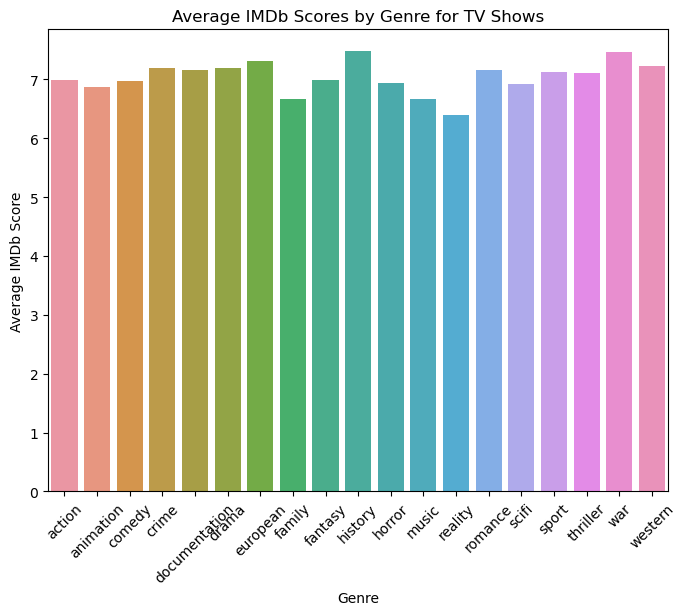

In [8]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('Normalised1.db')
sql_query = """
SELECT m.*, gs.Single_Genre, i.IMDb_Score
FROM Media m
INNER JOIN GenreSplit gs ON m.ID = gs.Media_ID
LEFT JOIN IMDb i ON m.IMDb_ID = i.IMDb_ID
WHERE m.Type = 'SHOW'
"""
df = pd.read_sql_query(sql_query, conn)
conn.close()

df['IMDb_Score'] = pd.to_numeric(df['IMDb_Score'], errors='coerce')
df = df.dropna(subset=['IMDb_Score'])

genre_score = df.groupby('Single_Genre')['IMDb_Score'].mean().reset_index()

plt.figure(figsize=(8, 6))
sns.barplot(x='Single_Genre', y='IMDb_Score', data=genre_score)
plt.xticks(rotation=45)
plt.title('Average IMDb Scores by Genre for TV Shows')
plt.xlabel('Genre')
plt.ylabel('Average IMDb Score')
plt.show()


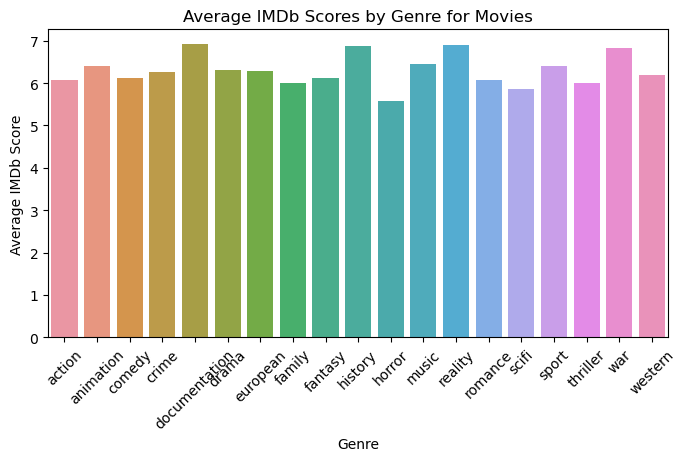

In [12]:

import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

conn = sqlite3.connect('Normalised1.db')

sql_query = """SELECT m.*, gs.Single_Genre, i.IMDb_Score
FROM Media m
INNER JOIN GenreSplit gs ON m.ID = gs.Media_ID
LEFT JOIN IMDb i ON m.IMDb_ID = i.IMDb_ID
WHERE m.Type = 'MOVIE'
"""
df = pd.read_sql_query(sql_query, conn)
conn.close()

df['IMDb_Score'] = pd.to_numeric(df['IMDb_Score'], errors='coerce')

df = df.dropna(subset=['IMDb_Score'])

genre_score = df.groupby('Single_Genre')['IMDb_Score'].mean().reset_index()

plt.figure(figsize=(8, 4))
sns.barplot(x='Single_Genre', y='IMDb_Score', data=genre_score)
plt.xticks(rotation=45)
plt.title('Average IMDb Scores by Genre for Movies')
plt.xlabel('Genre')
plt.ylabel('Average IMDb Score')
plt.show()


# MODEL TRAINING AND MODEL EVALUATION

In [16]:
import sqlite3
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Connect to the SQLite database
conn = sqlite3.connect('Normalised1.db')

# SQL query to select the necessary columns including age certificate and runtime
sql_query = """
SELECT m.Type, gs.Single_Genre, i.IMDb_Score, m.Age_Certification, m.Runtime
FROM Media m
INNER JOIN GenreSplit gs ON m.ID = gs.Media_ID
LEFT JOIN IMDb i ON m.IMDb_ID = i.IMDb_ID
"""


df = pd.read_sql_query(sql_query, conn)
conn.close()

df['IMDb_Score'] = pd.to_numeric(df['IMDb_Score'], errors='coerce')
df['Runtime'] = pd.to_numeric(df['Runtime'], errors='coerce')
df.dropna(subset=['IMDb_Score', 'Runtime'], inplace=True)

df_encoded = pd.get_dummies(df, columns=['Type', 'Single_Genre', 'Age_Certification'])

X = df_encoded.drop('IMDb_Score', axis=1)
y = df_encoded['IMDb_Score']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42)
}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name}: RMSE = {rmse}, MAE = {mae}")

Linear Regression: RMSE = 1.0220481815854343, MAE = 0.7902150190446965
Random Forest: RMSE = 1.0762424973779596, MAE = 0.8197721981989625
Gradient Boosting: RMSE = 0.9975178312219067, MAE = 0.7646618500328154


# MODEL PREDICTION 

In [26]:

comedy_tv_show_df = df[(df['Single_Genre'] == 'drama') & (df['Type'] == 'MOVIE') & (df['Age_Certification'] == 'PG')]

if comedy_tv_show_df.empty:
    print("No entries found for PG-rated Drama movies. Unable to make predictions.")
else:
  
    comedy_tv_show_encoded = pd.get_dummies(comedy_tv_show_df, columns=['Type', 'Single_Genre', 'Age_Certification'])

    for col in X_train.columns:
        if col not in comedy_tv_show_encoded.columns:
           
    comedy_tv_show_encoded = comedy_tv_show_encoded[X_train.columns]

    for name, model in models.items():
        predicted_scores = model.predict(comedy_tv_show_encoded)
        average_predicted_score = np.mean(predicted_scores)
        print(f"Average predicted IMDb score for PG-rated Drama movies using {name}: {average_predicted_score}")

Average predicted IMDb score for PG-rated Drama movies using Linear Regression: 6.311732466087921
Average predicted IMDb score for PG-rated Drama movies using Random Forest: 6.401978319758784
Average predicted IMDb score for PG-rated Drama movies using Gradient Boosting: 6.395790997933148
